# Project: Swedish Municipality KPI Analysis
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

### Problem Description

* What is the purpose of your study?  

The primary objective of this study is to explore and analyze the impact of higher education on population health in Swedish municipalities. This investigation aims to uncover the nuances of how educational attainment influences various health outcomes and social behaviors within these communities.

Specifically, the study will delve into the following key aspects:
* **The relationship between educational attainment and obesity:** 
Investigating whether lower educational attainment is associated with higher rates of obesity. 
* **The relationship between educational attainment and daily smoking:** 
Investigating the correlation between education levels and smoking habits.
* **The relationship between educational attainment and risky drinking:** 
Analyzing the impact of educational attainment on alcohol consumption patterns.

The study aims to provide insights into the broader significance of educational inconsistencies on public health and social behaviors. The findings are expected to contribute to a deeper understanding of the role of education in shaping health outcomes and social dynamics within Swedish municipalities, potentially informing policy decisions and community health initiatives. 

* Are there errors in the dataset? How did you deal with them? Explain your process and the reasoning behind it. 

* What are the (statistical) data types of the columns in your dataset? 
In our dataset we have a mix of nominal categorical data (`kpi`, `muncipality` and `gender`) and numerical data (`period` and `value`).
1. `kpi` (Key Performance Indicator ID): This column contains alphanumeric codes corresponding to the KPIs analyzed within this dataset. These are nominal data as they are used to identify the KPIs and do not have any inherent order or numerical value.
2. `municipality`: This column contains the names of the municipalities included in the dataset. These are nominal data  as they represent labels or identifiers for different municipalities and do not hold any quantitative value.
3. `period`: This column represents the year and is numerical and is considered as categorical data as it categorizes the data into different years.
4. `gender`: This column contains values K, M and T representing if there is a gender division for the datapoint. K for women, M for men and T for both.
5. `value`: This column contains the values for the KPIs. These are numerical data as they represent the actual values for the KPIs.

* Use a Q-Q plot to compare the distributions of different groups. What you are trying to observe? Why is it is important? Describe the results.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# Load the datasets
kpi_data_path = 'data/kpi_data.csv'
kpi_values_path = 'data/kpi_values.csv'
municipalities_data_path = 'data/municipalities_data.csv'

# Read the data
kpi_data = pd.read_csv(kpi_data_path)
kpi_values = pd.read_csv(kpi_values_path)
municipalities_data = pd.read_csv(municipalities_data_path)

# Displaying the first few rows of each dataset
print(f"{kpi_data.head()}\n")
print(f"{kpi_values.head()}\n")
print(f"{municipalities_data.head()}")

       id                                              title  \
0  N00000  Personalkostnader som andel av verksamhetens k...   
1  N00003                          Personalkostnader, kr/inv   
2  N00005     Utjämningssystemet enl resultaträkning, kr/inv   
3  N00009                   Intäkter kommunen totalt, kr/inv   
4  N00011  Inkomstutjämning, bidrag/avgift, kr/inv. 1 nov...   

                                         description municipality_type  \
0  Personalkostnader kommunen totalt, dividerat m...                 K   
1  Personalkostnader kommunen totalt, dividerat m...                 K   
2  Kommunalekonomisk utjämning kommun, dividerat ...                 K   
3  Externa intäkter exklusive intäkter från försä...                 K   
4  Inkomstutjämning, bidrag/avgift, i kronor per ...                 K   

   is_divided_by_gender  publ_period publication_date  
0                     0          NaN              NaN  
1                     0       2023.0       2024-08-31  
2 

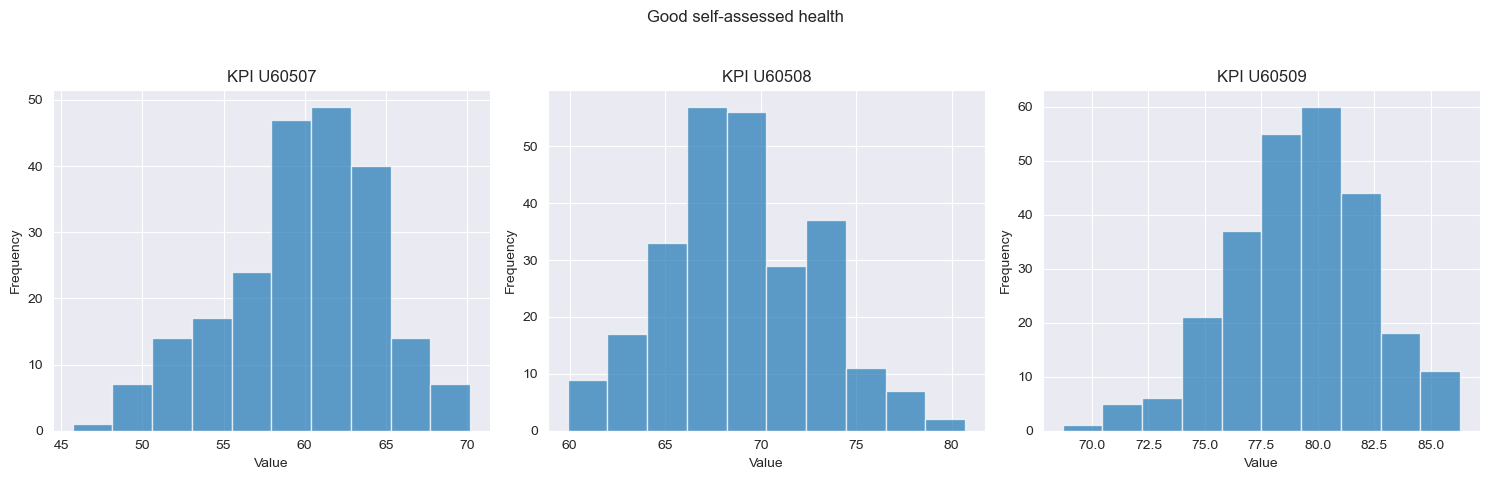

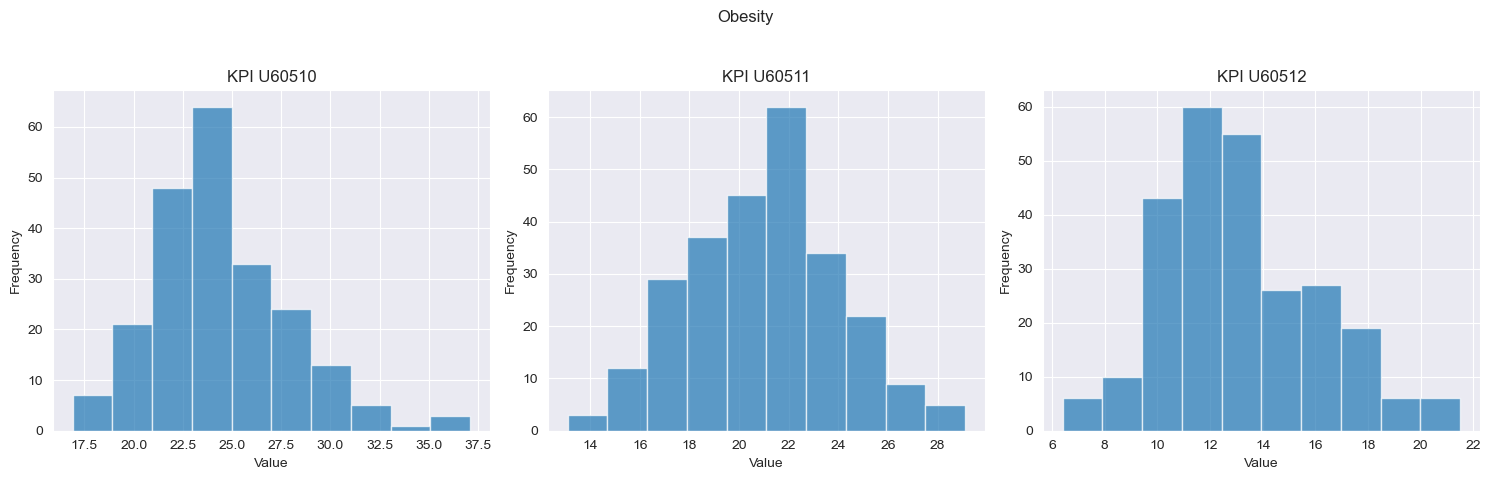

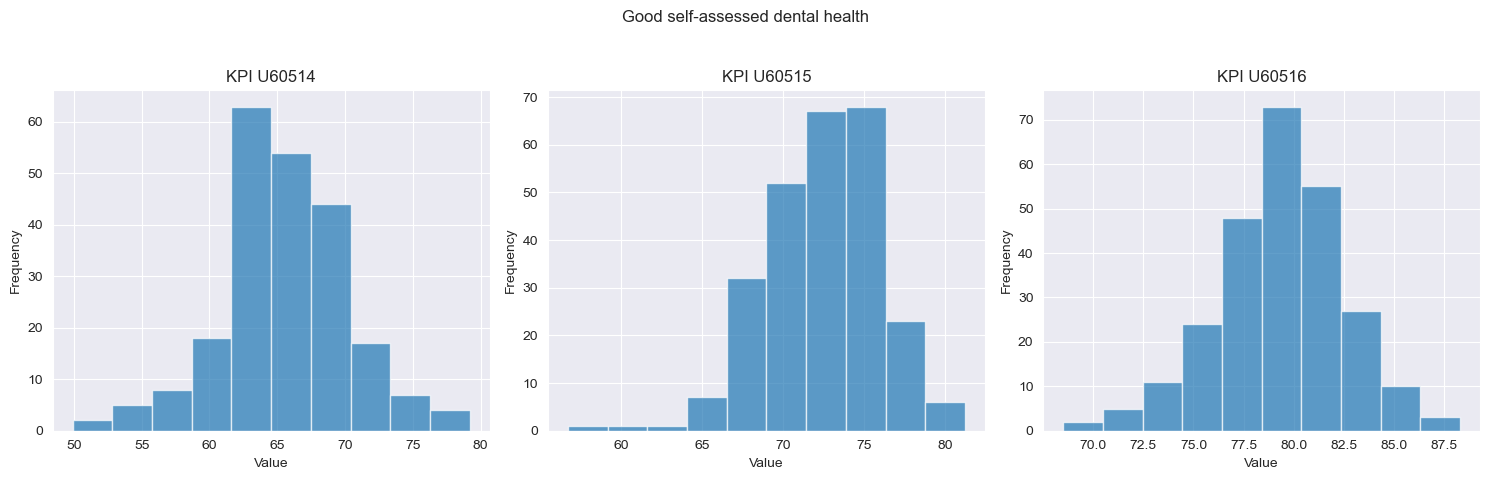

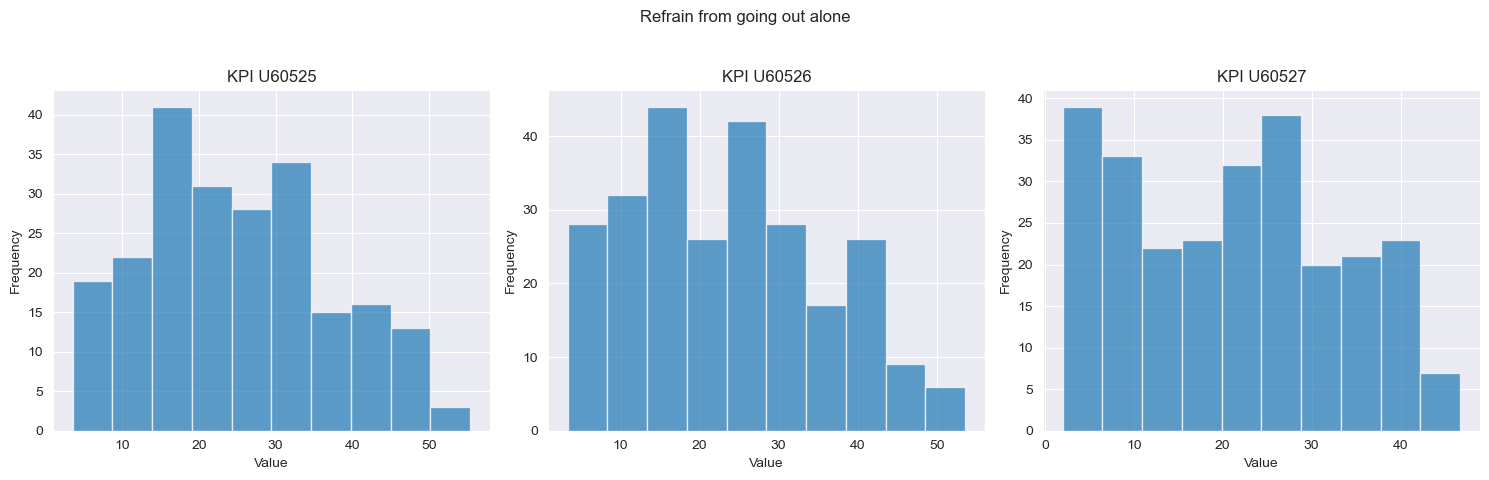

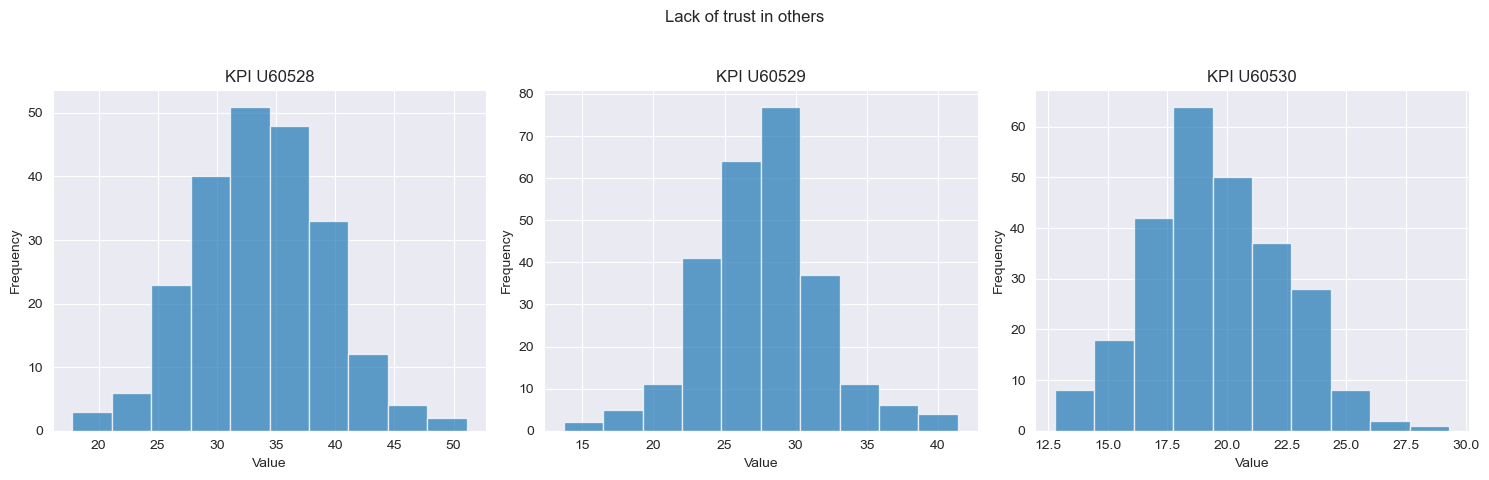

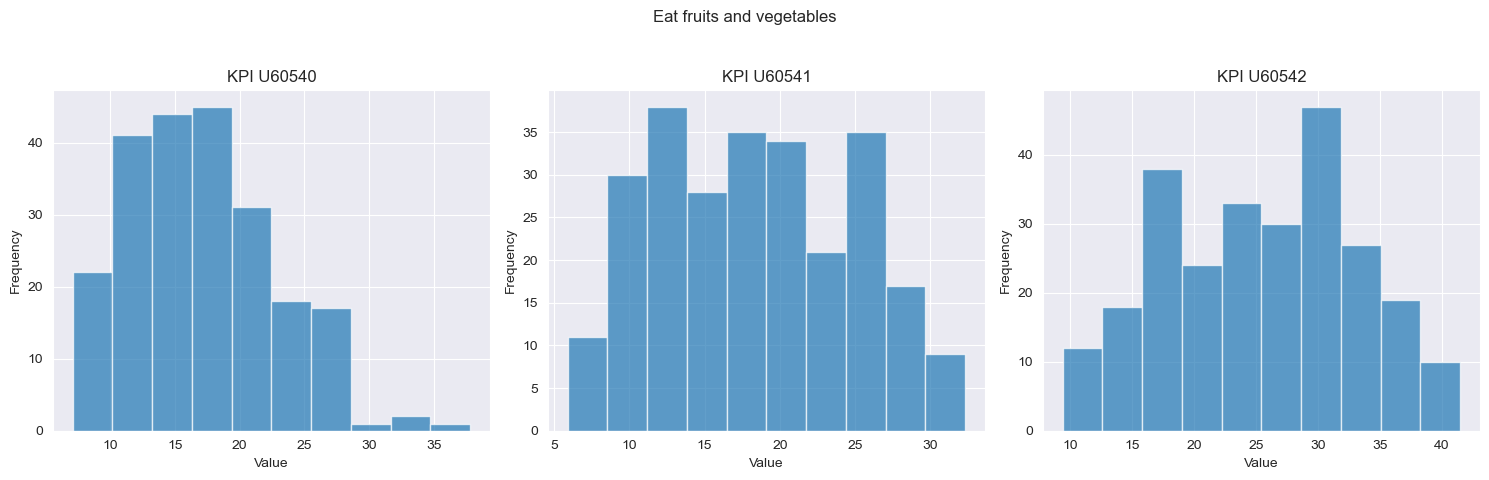

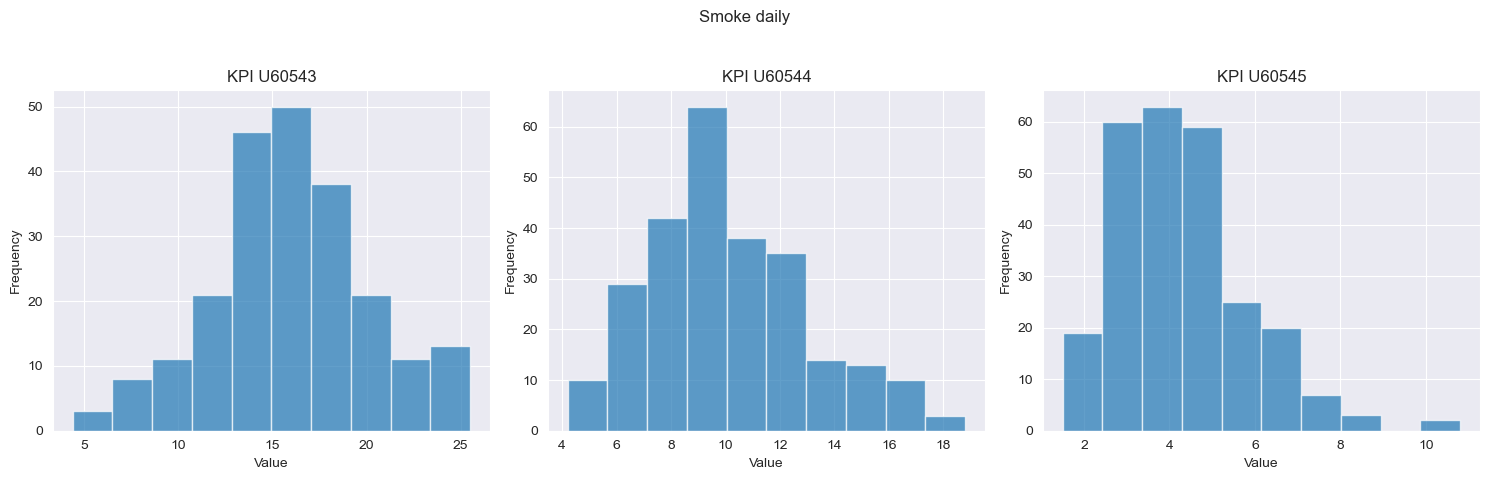

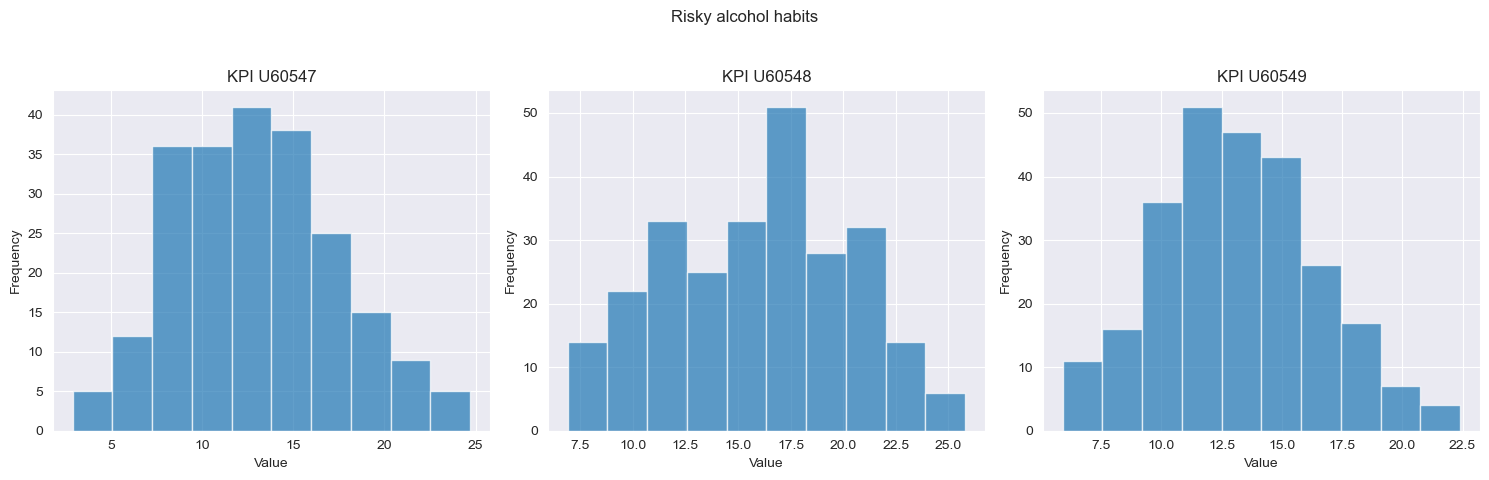

In [2]:
# Analysing the health contributors with different levels of education
# This is done to determine what KPIs are relevant to our analysis
education_health_kpis = [
    'U60507', 'U60508', 'U60509', # Good self-assessed health
    'U60510', 'U60511', 'U60512', # Obesity
    'U60514', 'U60515', 'U60516', # Good self-assessed dental health
    'U60525', 'U60526', 'U60527', # Refrain from going out alone
    'U60528', 'U60529', 'U60530', # Lack of trust in others
    'U60540', 'U60541', 'U60542', # Eat fruits and vegetables
    'U60543', 'U60544', 'U60545', # Smoke daily
    'U60547', 'U60548', 'U60549'  # Risky alcohol habits
]

# Filter the kpi_values dataframe for the KPIs of interest
filtered_df = kpi_values[kpi_values['kpi'].isin(education_health_kpis)]

kpi_groups = {
    'Good self-assessed health': ['U60507', 'U60508', 'U60509'],
    'Obesity': ['U60510', 'U60511', 'U60512'],
    'Good self-assessed dental health': ['U60514', 'U60515', 'U60516'],
    'Refrain from going out alone': ['U60525', 'U60526', 'U60527'],
    'Lack of trust in others': ['U60528', 'U60529', 'U60530'],
    'Eat fruits and vegetables': ['U60540', 'U60541', 'U60542'],
    'Smoke daily': ['U60543', 'U60544', 'U60545'],
    'Risky alcohol habits': ['U60547', 'U60548', 'U60549']
}

# Create subplots for each category
for category, kpis in kpi_groups.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    fig.suptitle(category)

    for i, kpi in enumerate(kpis):
        subset = filtered_df[filtered_df['kpi'] == kpi]
        axes[i].hist(subset['value'], bins=10, alpha=0.7)
        axes[i].set_title(f'KPI {kpi}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

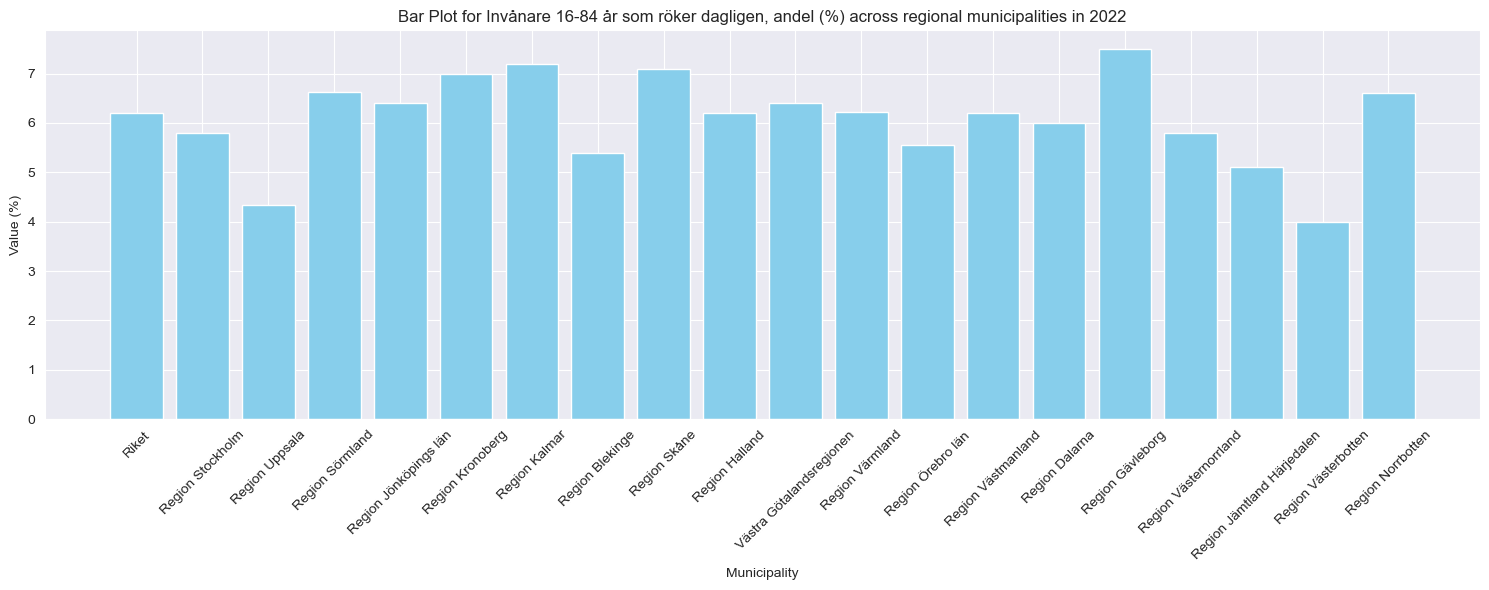

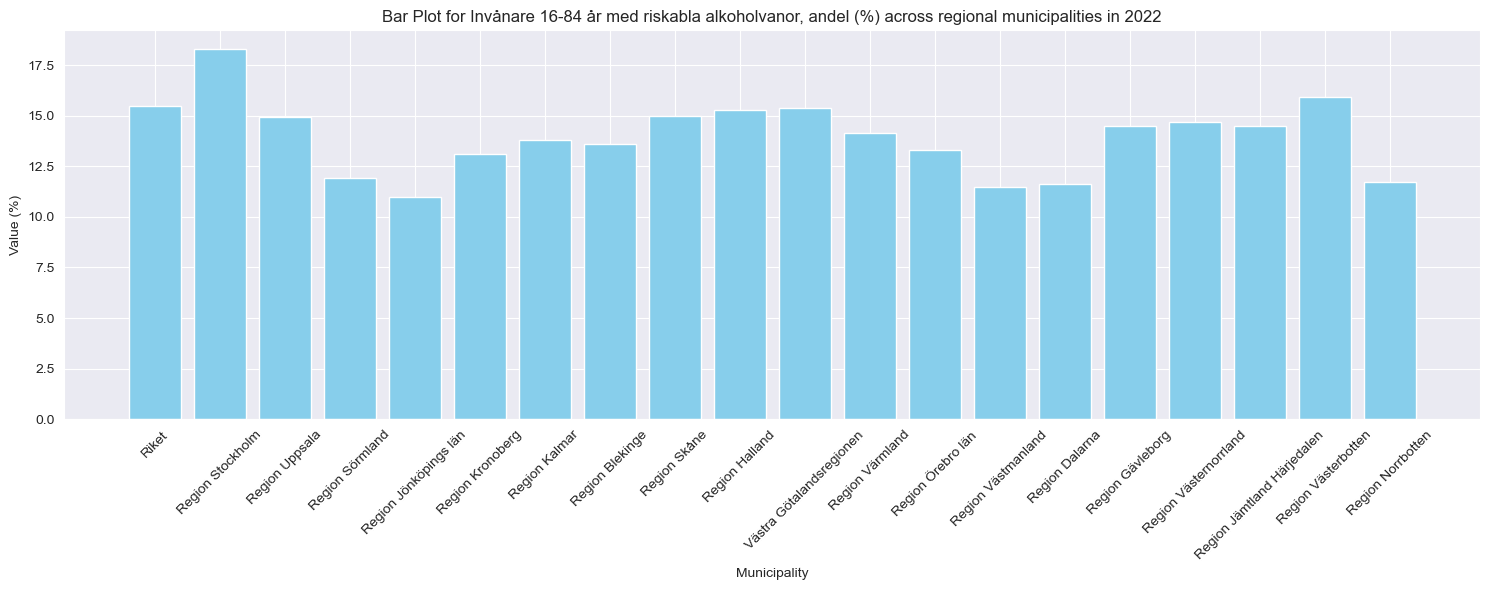

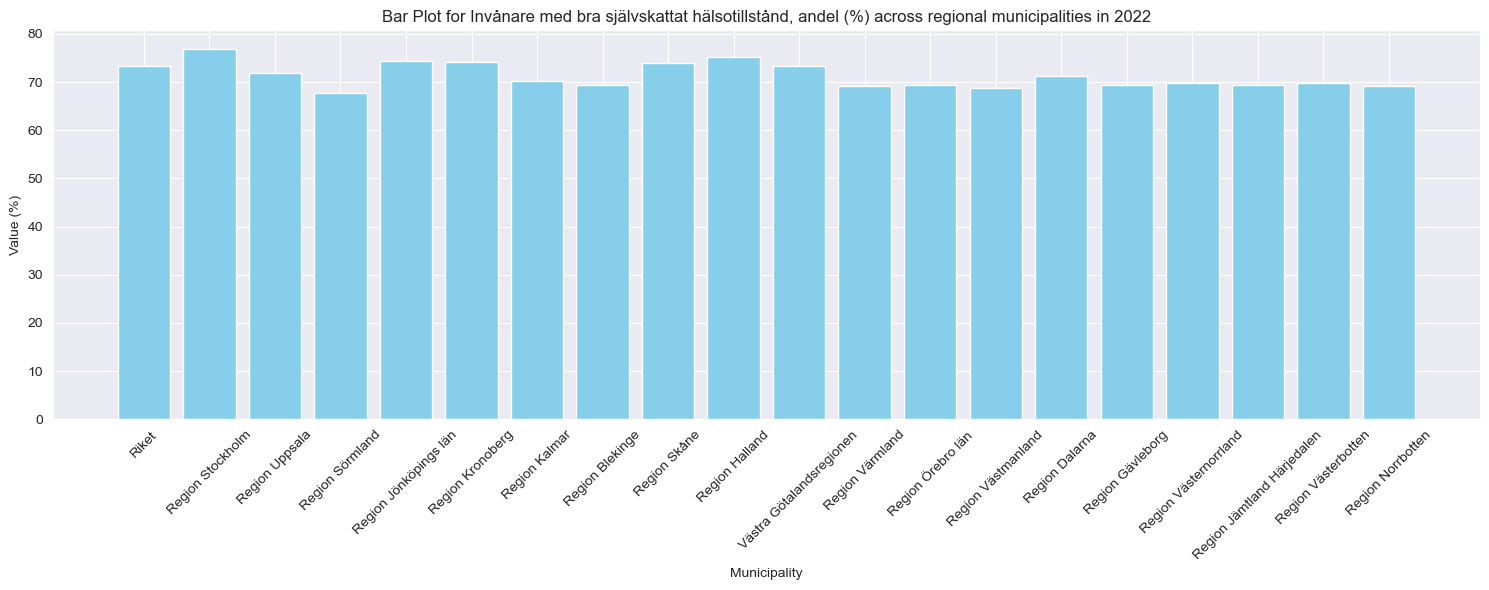

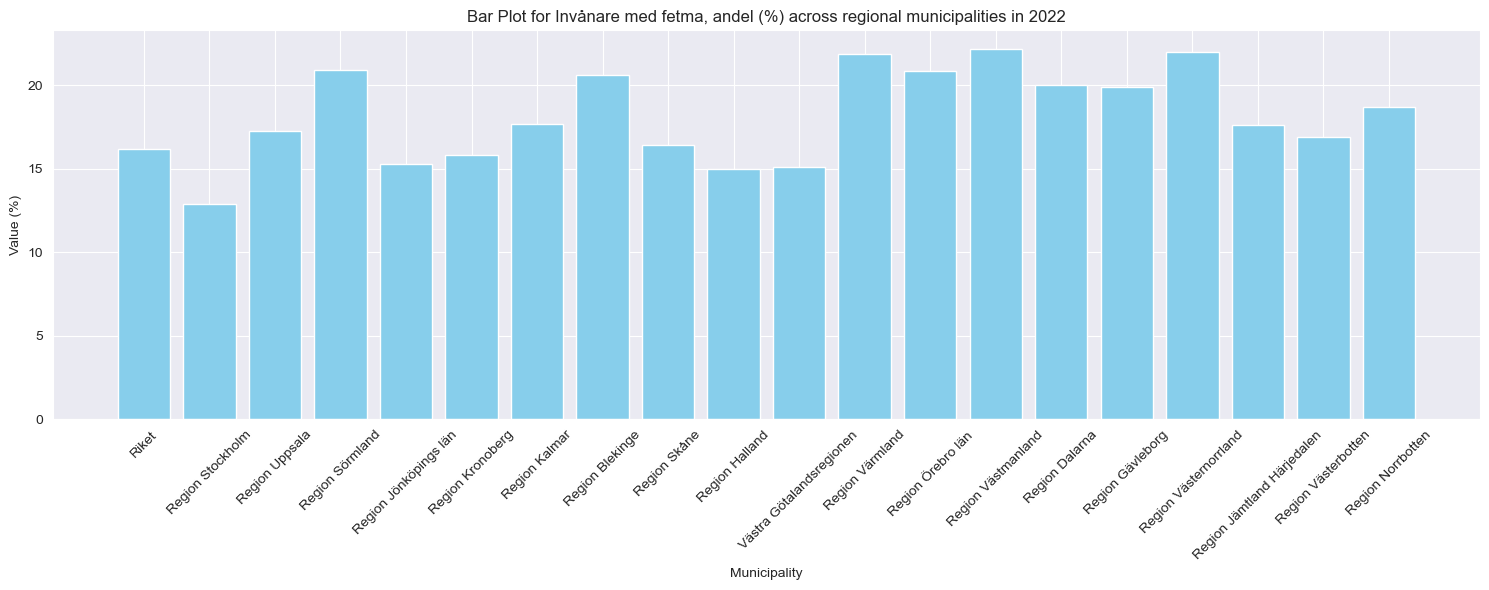

In [3]:
# Bar plots describing the distribution of the KPIs within each municipality
# Define the KPIs of interest
health_indicator_kpis = ['U01402', 'U01404', 'U01405', 'U01411']

# Create a dictionary to map KPI IDs to their names
kpi_names = pd.Series(kpi_data.title.values, index=kpi_data.id).to_dict()

# Create a dictionary to map municipality codes to their names
municipality_names = pd.Series(municipalities_data.title.values, index=municipalities_data.id).to_dict()

# Define the municipality codes for the regional municipalities
regional_municipality_codes = [0, 1, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25]

# Filter and plot data for each KPI
for kpi in health_indicator_kpis:
    # Filter for the KPI, total population, the year 2022, and the specified municipalities
    kpi_data_filtered = kpi_values[(kpi_values['kpi'] == kpi) &
                                   (kpi_values['gender'] == 'T') &
                                   (kpi_values['period'] == 2022) &
                                   (kpi_values['municipality'].isin(regional_municipality_codes))].copy()

    # Get the name of the KPI
    kpi_name = kpi_names.get(kpi, "Unknown KPI")

    # Map the municipality codes to names directly using the dictionary
    kpi_data_filtered['municipality_name'] = kpi_data_filtered['municipality'].map(municipality_names)

    # Check if there are any 'Unknown' mappings which can indicate a mismatch in the data
    if 'Unknown' in kpi_data_filtered['municipality_name'].values:
        print(f"Warning: Some municipality codes could not be found in the mapping dictionary for KPI {kpi}")

    # Plotting the bar plot
    plt.figure(figsize=(15, 6))
    plt.bar(kpi_data_filtered['municipality_name'], kpi_data_filtered['value'], color='skyblue')
    plt.title(f'Bar Plot for {kpi_name} across regional municipalities in 2022')
    plt.xlabel('Municipality')
    plt.ylabel('Value (%)')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()

In [4]:
# List of KPI IDs for each category
health_kpis = ['N00351', 'N00362', 'N00923', 'N00925', 'U01402', 'U01405', 'U01411']
education_kpis = ['N00352', 'N00363']
income_kpis = ['N00348', 'N00359', 'N00349', 'N00360', 'N00906', 'N00907']

# Filtering the kpi_values dataframe to create separate dataframes for each category
health_df = kpi_values[kpi_values['kpi'].isin(health_kpis)]
education_df = kpi_values[kpi_values['kpi'].isin(education_kpis)]
income_df = kpi_values[kpi_values['kpi'].isin(income_kpis)]

# Display the first few rows of each filtered dataframe to verify
print(f"{health_df.head()}\n")
print(f"{education_df.head()}\n")
print(f"{income_df.head()}\n")

         kpi  municipality  period gender      value
3182  N00351             0    2022      T  63.598955
3183  N00351             1    2022      T  82.754882
3184  N00351             3    2022      T  68.787137
3185  N00351             4    2022      T  36.220026
3186  N00351             5    2022      T  69.022839

         kpi  municipality  period gender      value
3204  N00352             0    2022      T  55.581171
3205  N00352             1    2022      T  56.368334
3206  N00352             3    2022      T  58.781354
3207  N00352             4    2022      T  48.612333
3208  N00352             5    2022      T  55.041985

         kpi  municipality  period gender      value
3116  N00348             0    2022      T  23.053445
3117  N00348             1    2022      T  48.697470
3118  N00348             3    2022      T  22.569836
3119  N00348             4    2022      T   3.667282
3120  N00348             5    2022      T  21.125893


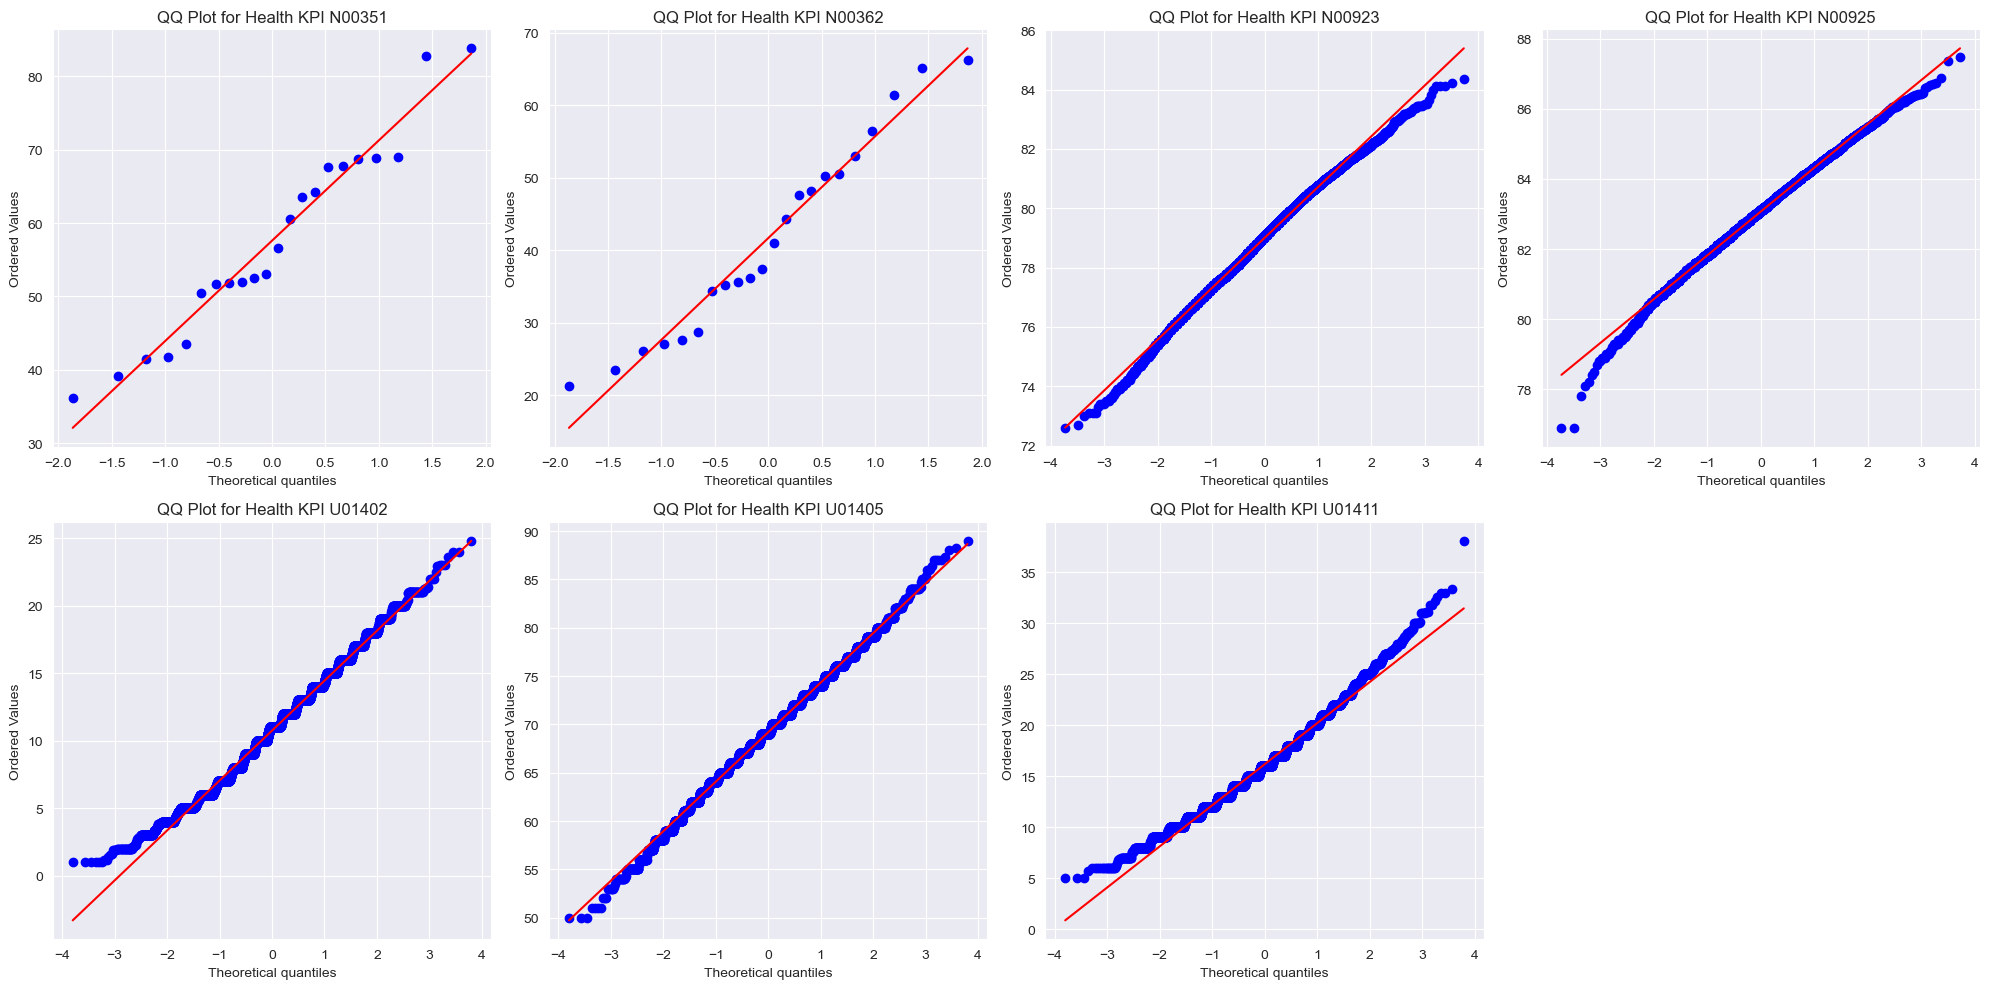

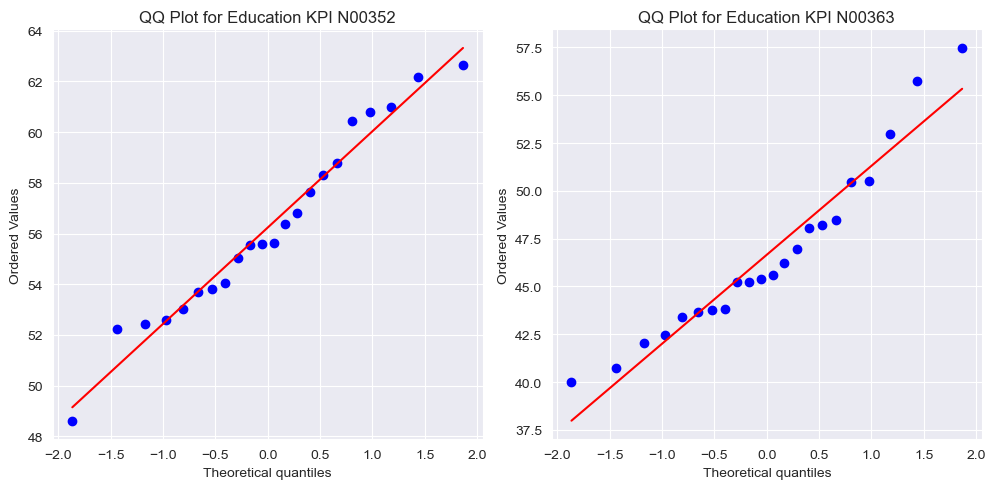

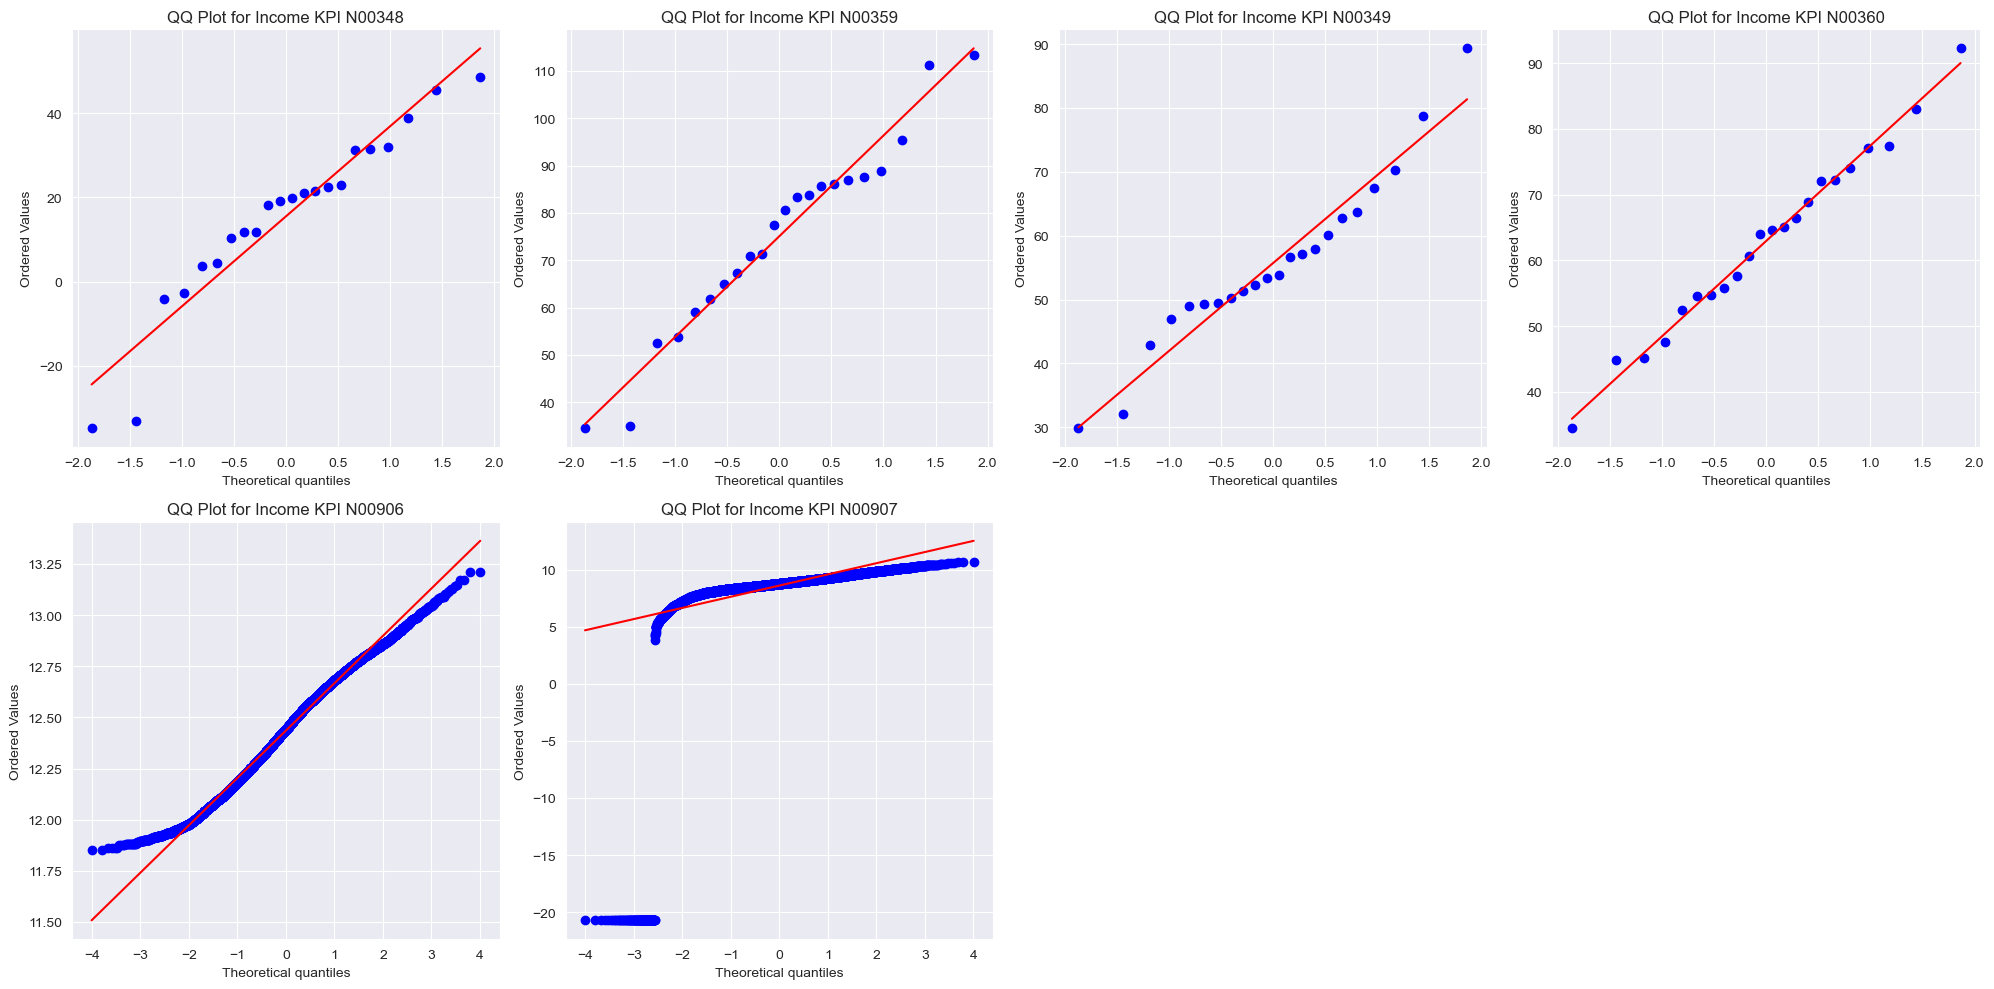

In [5]:
# Define which KPIs should be log-transformed
log_transform_kpis = ['N00906', 'N00907']

def create_qq_plots_for_kpis(kpi_list, df, category_name):
    # Define the number of rows and columns for the subplot grid
    num_plots = len(kpi_list)
    cols = 4  # We choose 4 columns for our grid
    rows = num_plots // cols + (num_plots % cols > 0)  # This ensures we have enough rows for all KPIs

    # Create the subplots with the desired number of rows and columns
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Flatten the Axes array if there are multiple rows
    if num_plots > cols:
        axs = axs.flatten()

    for i, kpi in enumerate(kpi_list):
        # Filter for the KPI and total population
        data = df[df['kpi'] == kpi]['value']

        # Check if log transformation is needed
        if kpi in log_transform_kpis:
            # Apply log transformation, avoiding log(0) by adding a small constant
            data = np.log(data + 1e-9)

        # Generate QQ plot
        stats.probplot(data, dist="norm", plot=axs[i])
        axs[i].set_title(f'QQ Plot for {category_name} KPI {kpi}')

    # Hide any unused subplots
    for i in range(num_plots, rows * cols):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

# Generate QQ plots for health KPIs
create_qq_plots_for_kpis(health_kpis, health_df, 'Health')
create_qq_plots_for_kpis(education_kpis, education_df, 'Education')
create_qq_plots_for_kpis(income_kpis, income_df, 'Income')

 ### Exploratory Data Analysis

* Show the histogram of some selected KPIs and describe your observation.
* Show the dependence of some selected variables and describe your observation.
* Describe the data using its range, sample mean, sample standard deviation and some quantiles. Describe your observation.
* Choose another visualization method to explore the data set.
* Draw conclusion from your exploratory analysis

### Descriptive Statistics

In [6]:
# Combine all the KPIs into a single dataframe
all_kpis_df = pd.concat([health_df, education_df, income_df])

# Determine the number of unique KPIs in each category
unique_kpis = all_kpis_df['kpi'].unique()

# Calculate descriptive statistics for each unique KPI
descriptive_stats = {kpi_names[kpi]: all_kpis_df[all_kpis_df['kpi'] == kpi]['value'].describe()
                     for kpi in unique_kpis}

# Create a formatted string for better readability
formatted_stats = ""
for kpi, stats in descriptive_stats.items():
    formatted_stats += f"Descriptive statistics for {kpi}:\n{stats}\n\n"

# Print the formatted descriptive statistics
print(formatted_stats)

Descriptive statistics for Hälsa – Regionindex Kvinnor:
count    22.000000
mean     57.605826
std      13.277871
min      36.220026
25%      50.773805
50%      54.849984
75%      67.735886
max      83.833148
Name: value, dtype: float64

Descriptive statistics for Hälsa – Regionindex Män:
count    22.000000
mean     41.654250
std      13.576229
min      21.252717
25%      30.145915
50%      39.170170
75%      50.404391
max      66.242924
Name: value, dtype: float64

Descriptive statistics for Medellivslängd män, år:
count    7158.000000
mean       78.999892
std         1.716899
min        72.600000
25%        77.800000
50%        79.075000
75%        80.230000
max        84.370000
Name: value, dtype: float64

Descriptive statistics for Medellivslängd kvinnor, år:
count    7158.000000
mean       83.067685
std         1.250349
min        76.900000
25%        82.200000
50%        83.100000
75%        83.920000
max        87.480000
Name: value, dtype: float64

Descriptive statistics for Inv

### Histograms

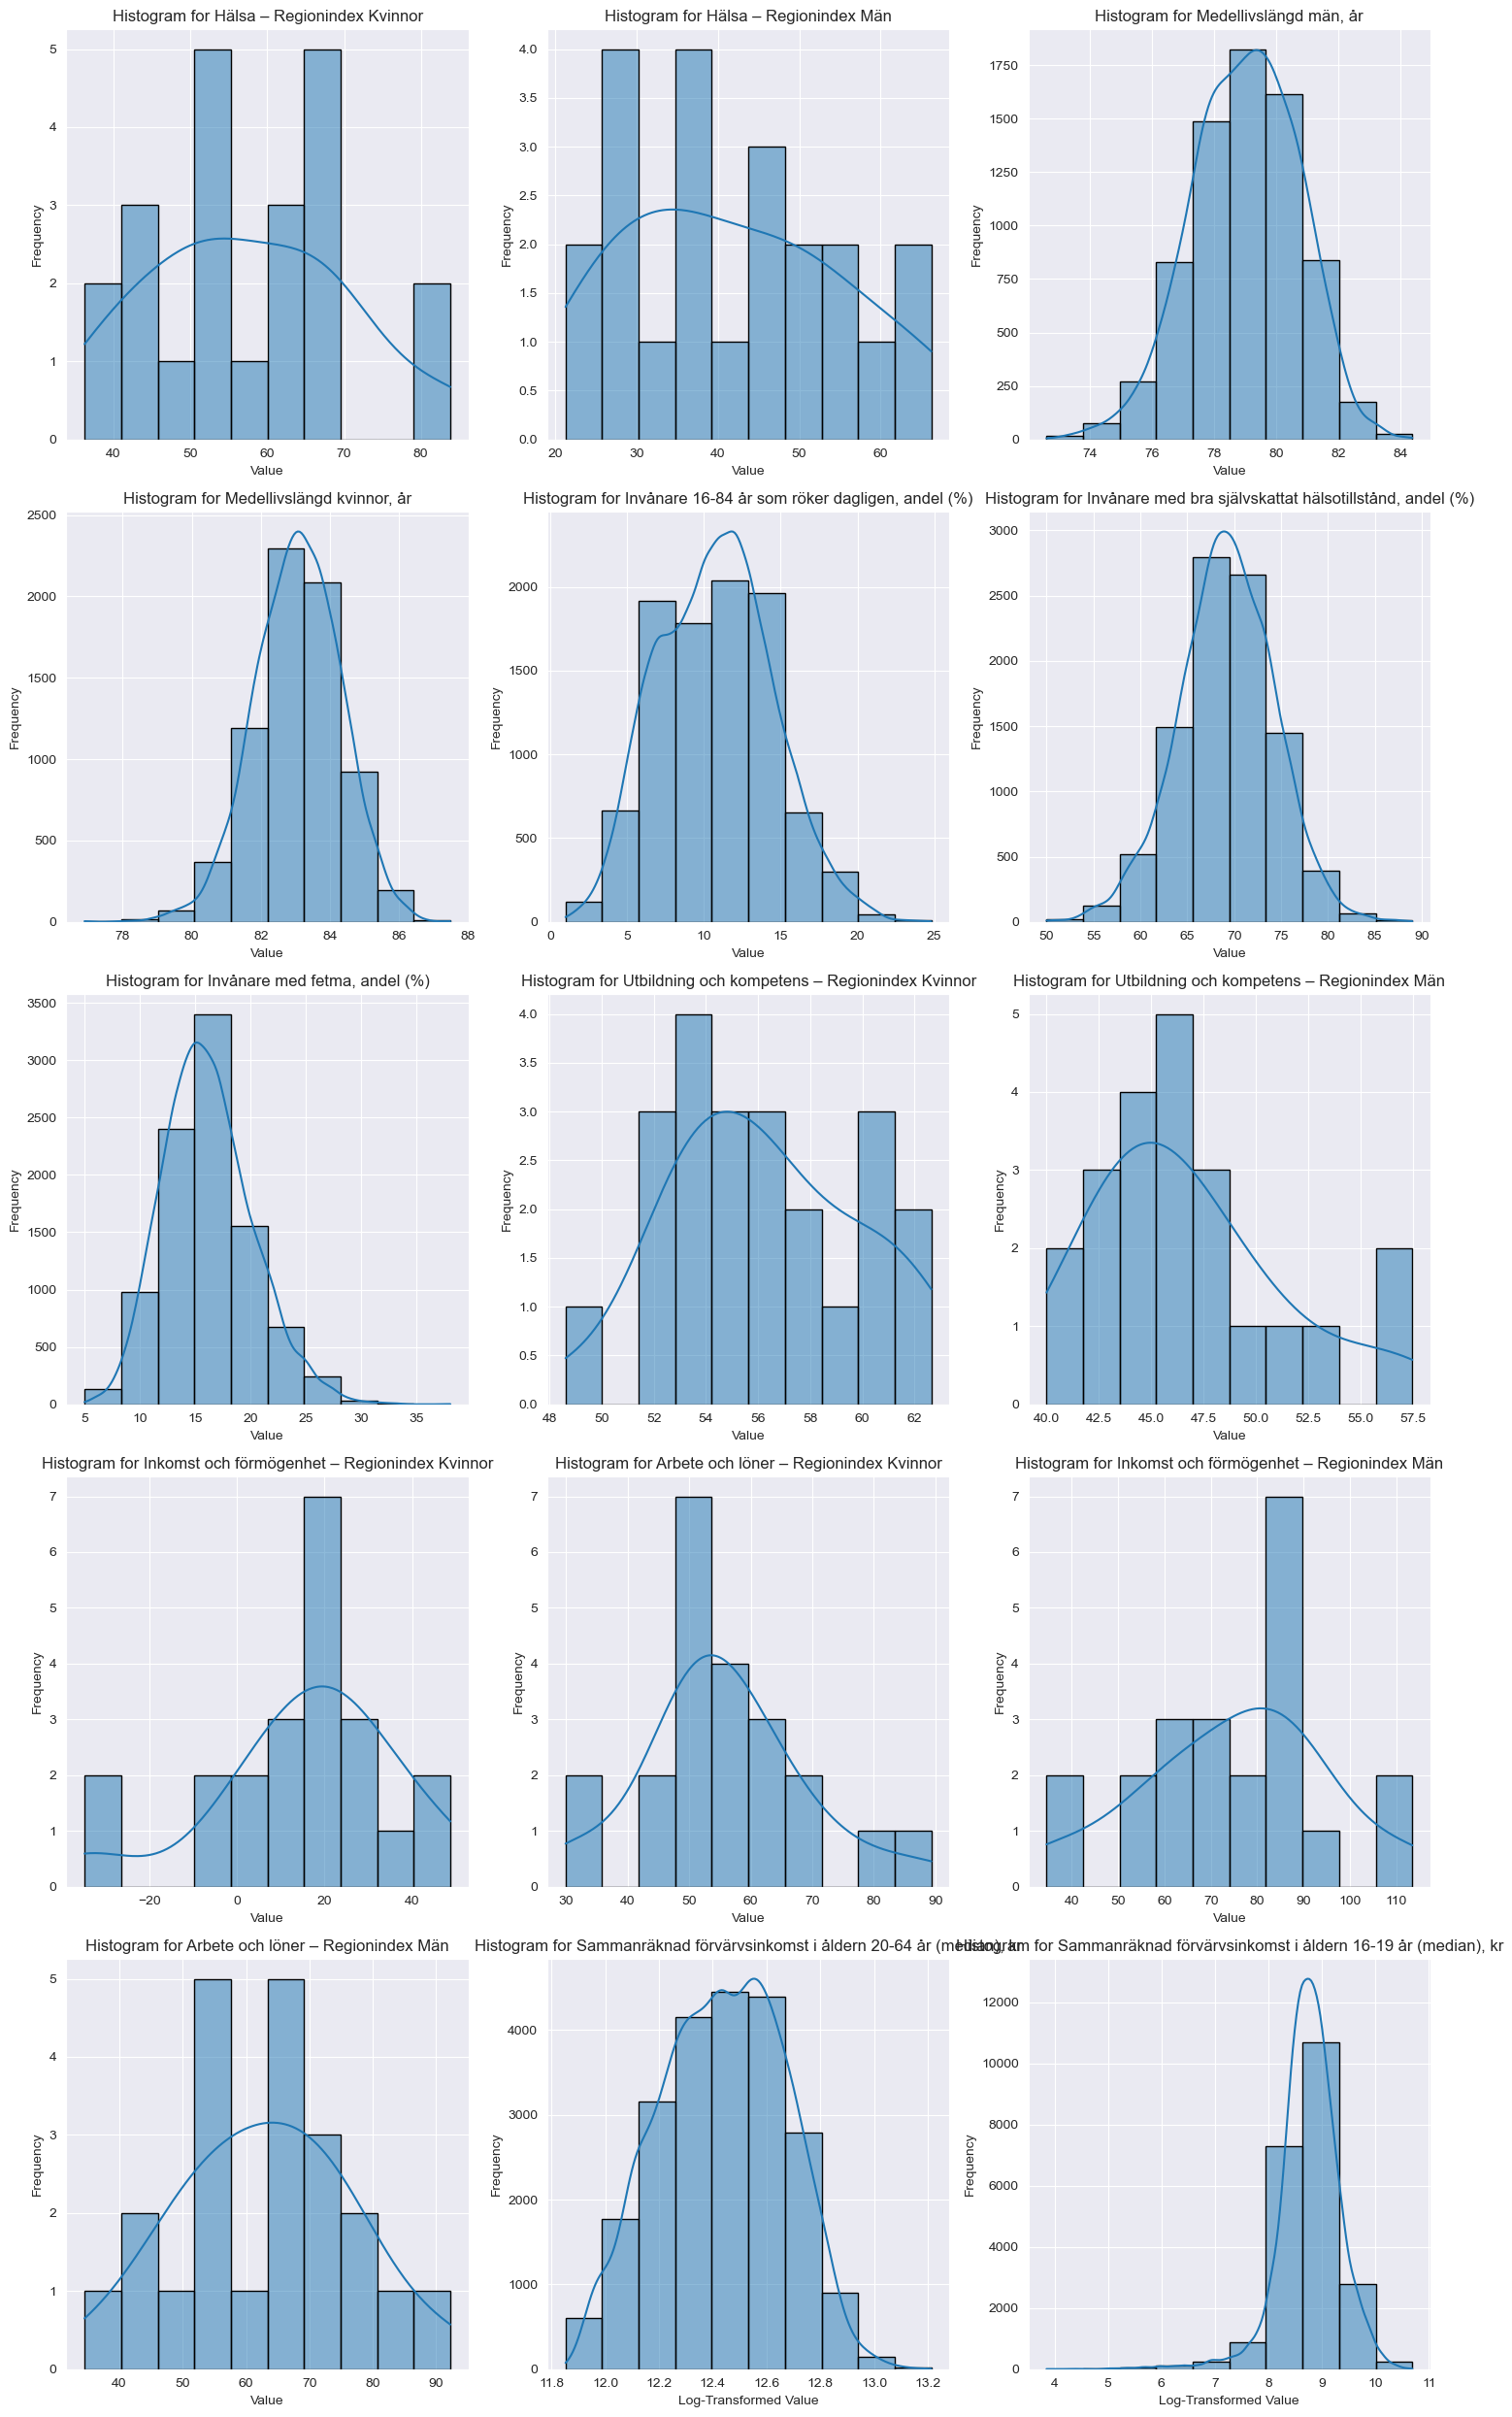

In [7]:
# Combine all the lists to create a master list of KPIs
all_kpis = health_kpis + education_kpis + income_kpis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_kpi_histograms(df, kpi_names, raw_income_kpis, num_bins=10, num_cols=3):
    # Extract unique KPIs from the DataFrame
    unique_kpis = df['kpi'].unique()

    # Adjust the size of the plot based on the number of unique KPIs
    num_rows = len(unique_kpis) // num_cols + (len(unique_kpis) % num_cols > 0)  # Calculate the number of rows needed
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the size dynamically

    # Check if axs is an array of axes, if not, wrap it in an array for consistency
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Flatten the Axes array for easy iteration
    axs = axs.flatten()

    # Plot a histogram for each KPI
    for i, kpi in enumerate(unique_kpis):
        # Select the data for the current KPI
        data = df[df['kpi'] == kpi]['value']

        # If the current KPI is in the list of income KPIs, apply a log transform to positive values only
        if kpi in raw_income_kpis:
            data = data[data > 0]  # Filter out non-positive values
            data = np.log(data)  # Apply log transformation
            axs[i].set_xlabel('Log-Transformed Value')
        else:
            axs[i].set_xlabel('Value')

        # Plot the histogram using seaborn
        sns.histplot(data, bins=num_bins, ax=axs[i], kde=True, edgecolor='black')

        # Map the kpi to its name for the title
        kpi_name = kpi_names.get(kpi, kpi)
        axs[i].set_title(f'Histogram for {kpi_name}')
        axs[i].set_ylabel('Frequency')

    # Hide any unused axes if the number of KPIs doesn't fill the grid
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

raw_income_kpis = ['N00906', 'N00907']  # List of raw income KPI IDs
plot_kpi_histograms(all_kpis_df, kpi_names, raw_income_kpis)

### Histogram: Observations

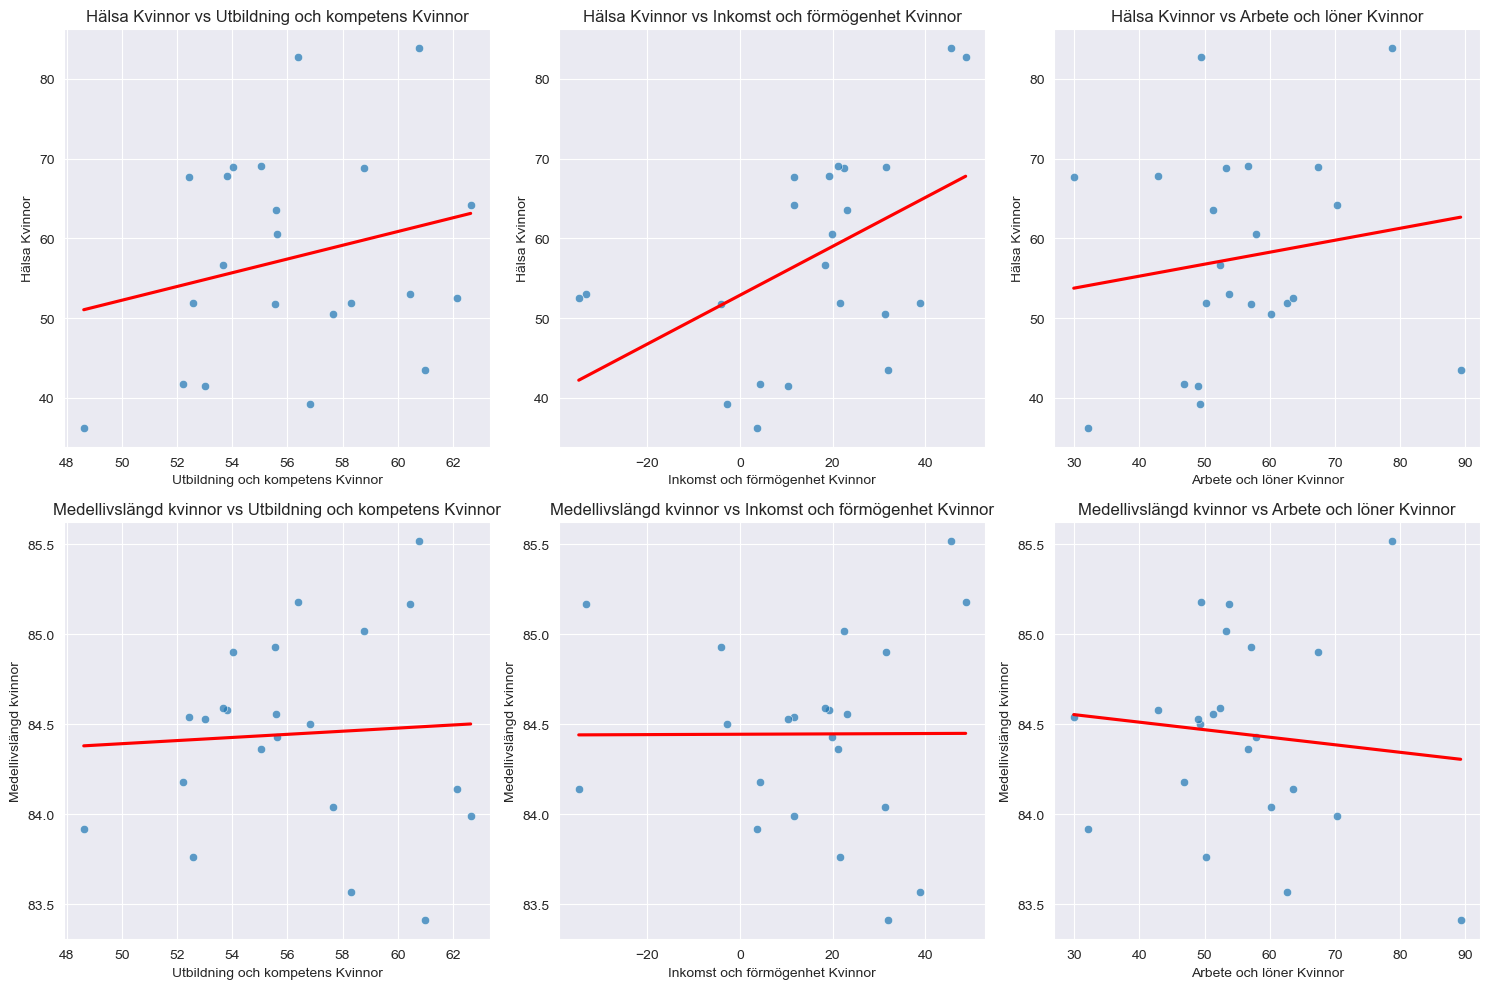

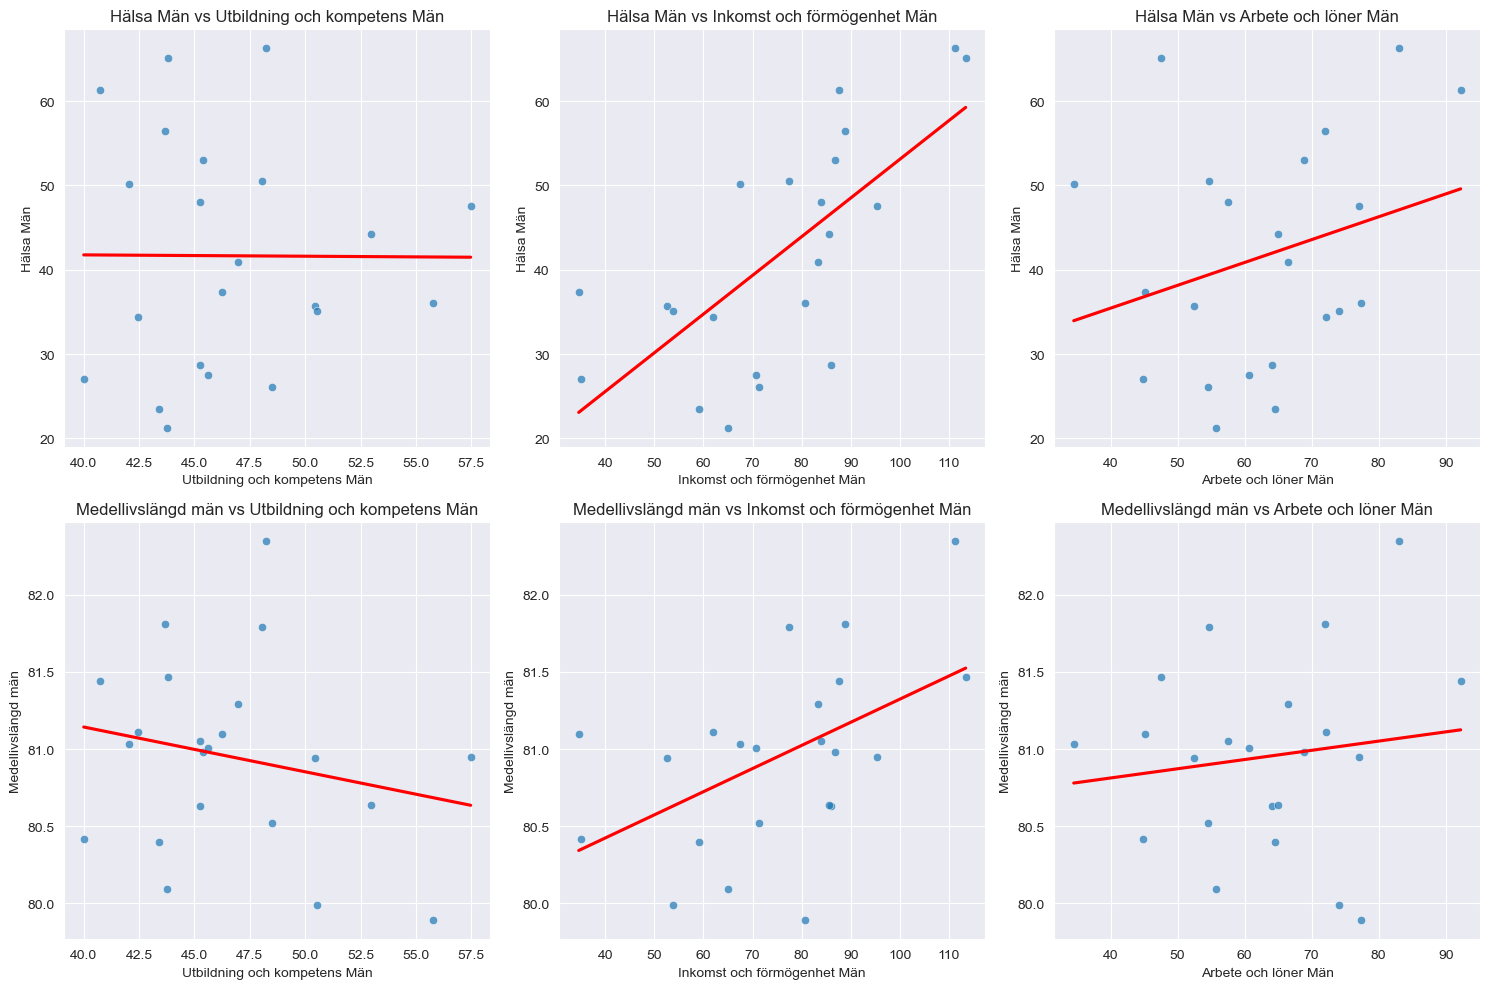

In [8]:
# Dependent variable: Hälsa – Regionindex Kvinnor N00351, Hälsa – Regionindex Män N00362, Medellivslängd män N00923, Medellivslängd kvinnor N00925
# Independent variables: Utbildning och kompetens Kvinnor N00352, Utbildning och kompetens Män N00363, Inkomst och förmögenhet Kvinnor N00348, Inkomst och förmögenhet Män N00359, Arbete och löner Kvinnor N00349, Arbete och löner Män N00360, Aggregated income 20-64 N00906, Aggregated income 16-19 N00907
# Plots: Scatter plots, Heatmaps, Pair plot/Scatter plot matrices
# Correlation Coefficients: Pearson, Spearman

# Filter the DataFrame to only include data from the year 2022
df_2022 = all_kpis_df[all_kpis_df['period'] == 2022]

# Define dependent and independent variables for women
dependent_vars_women = ['N00351', 'N00925']  # Women's health and life expectancy
independent_vars_women = ['N00352', 'N00348', 'N00349']  # Women's education, income, work and wages

# Define dependent and independent variables for men
dependent_vars_men = ['N00362', 'N00923']  # Men's health and life expectancy
independent_vars_men = ['N00363', 'N00359', 'N00360']  # Men's education, income, work and wages

# Function to create scatter plots with trend lines for a given gender
def create_scatter_plots(df, dependent_vars, independent_vars, kpi_names):
    # Calculate the total number of plots
    total_plots = len(dependent_vars) * len(independent_vars)

    # Define the number of columns
    cols = 3

    # Calculate the number of rows needed
    rows = total_plots // cols + (total_plots % cols > 0)

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    # Plot counter
    plot_count = 0

    for dep_var in dependent_vars:
        for ind_var in independent_vars:
            # Merge the data on 'municipality' for the specific KPIs
            dep_data = df[df['kpi'] == dep_var]
            ind_data = df[df['kpi'] == ind_var]
            merged_data = pd.merge(dep_data, ind_data, on='municipality', suffixes=('_dep', '_ind'))

            # Look up the KPI names using the kpi_names dictionary
            dep_var_name = kpi_names[dep_var] if dep_var in kpi_names else dep_var
            ind_var_name = kpi_names[ind_var] if ind_var in kpi_names else ind_var

            # Remove 'Regionindex' from the names and split at '–' and remove ', år'
            dep_var_name = ' '.join([part.strip() for part in dep_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()
            ind_var_name = ' '.join([part.strip() for part in ind_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()

            # Create the scatter plot on the appropriate subplot
            sns.scatterplot(x=merged_data['value_ind'], y=merged_data['value_dep'], alpha=0.7, ax=axs[plot_count])
            sns.regplot(x=merged_data['value_ind'], y=merged_data['value_dep'], scatter=False, ci=None, color='red', ax=axs[plot_count])

            # Set the title with the KPI names
            axs[plot_count].set_title(f'{dep_var_name} vs {ind_var_name}')
            axs[plot_count].set_xlabel(f'{ind_var_name}')
            axs[plot_count].set_ylabel(f'{dep_var_name}')

            # Increment the plot counter
            plot_count += 1

    # Hide any unused subplots
    for i in range(plot_count, rows * cols):
        fig.delaxes(axs[i])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Create scatter plots for women
create_scatter_plots(df_2022, dependent_vars_women, independent_vars_women, kpi_names)

# Create scatter plots for men
create_scatter_plots(df_2022, dependent_vars_men, independent_vars_men, kpi_names)

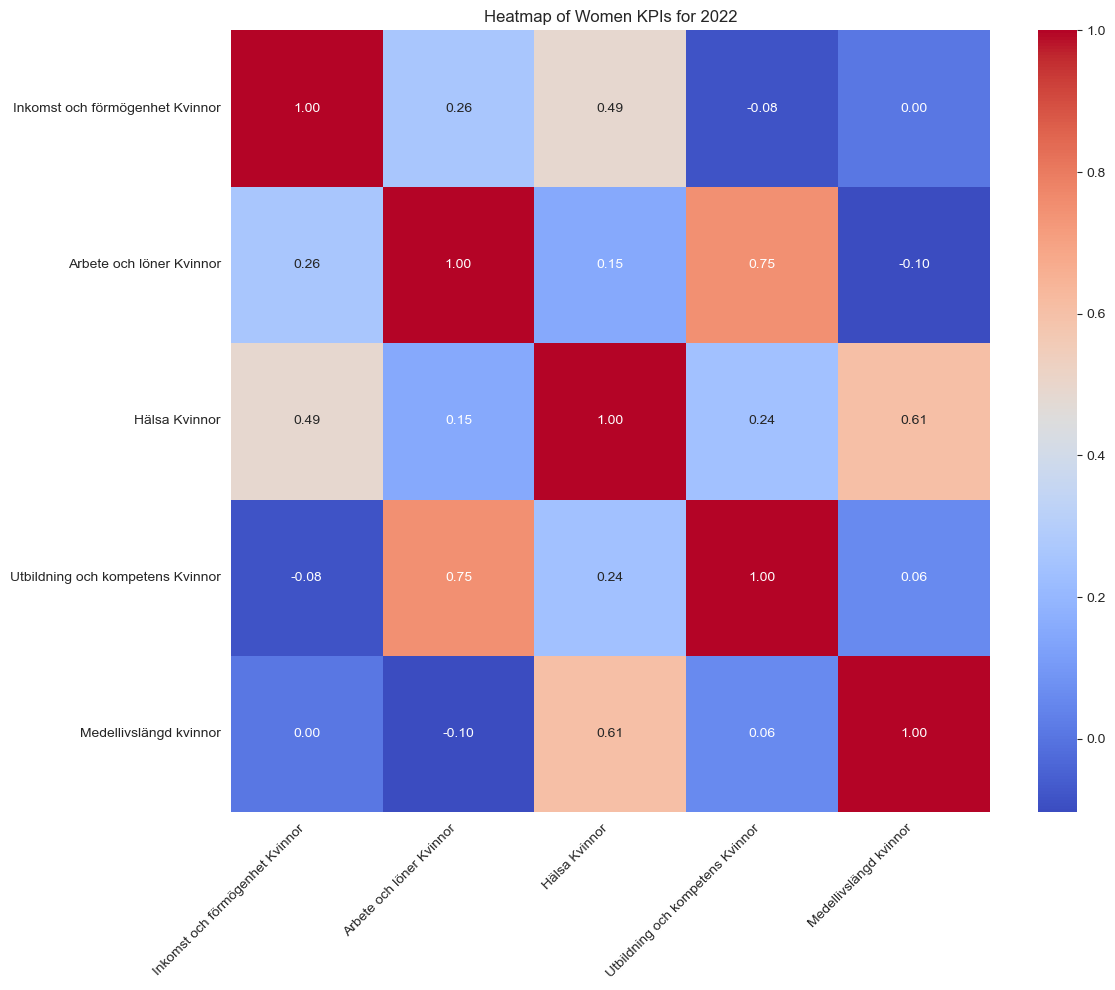

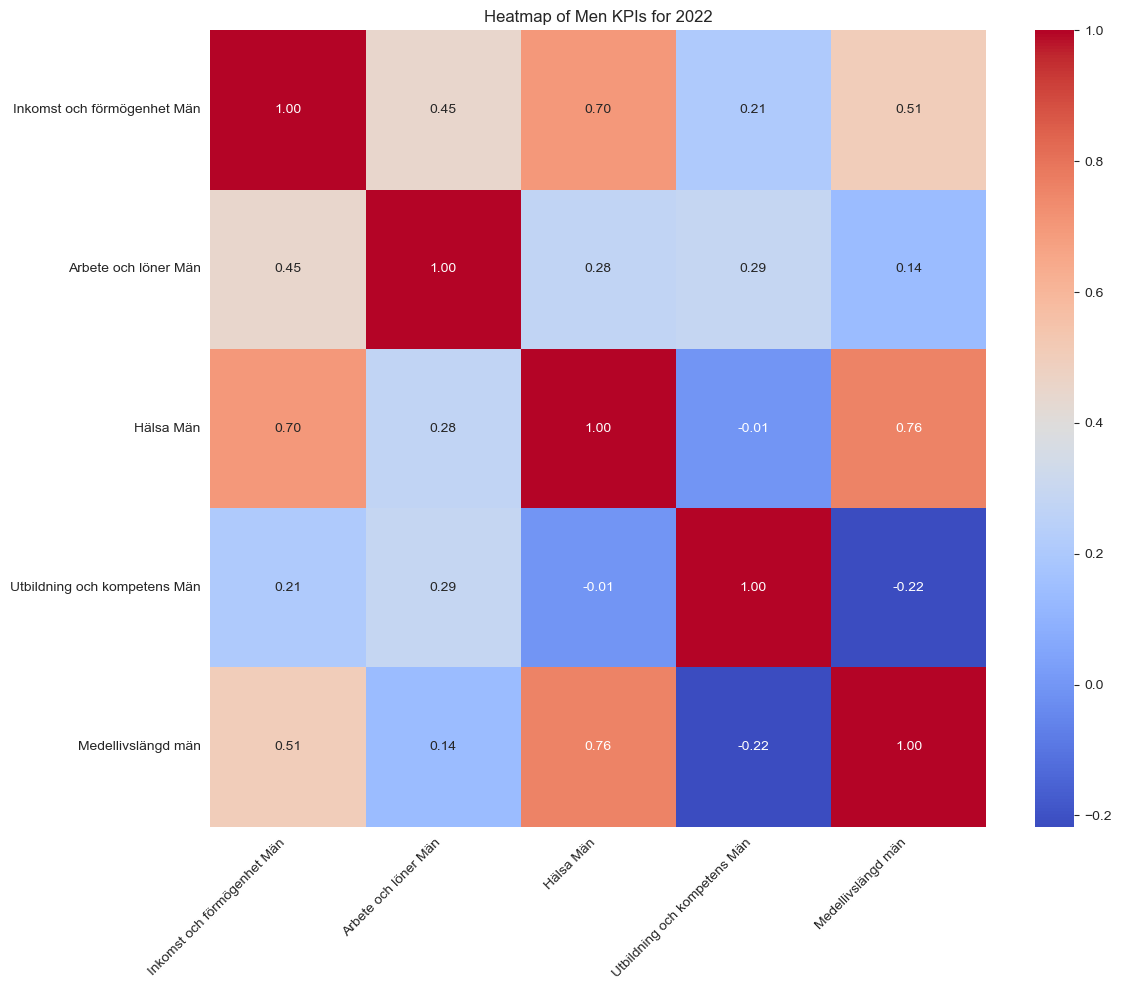

In [9]:
def create_heatmap(df, kpi_names, vars, gender):
    # Filter the DataFrame for the combined variables
    heatmap_df = df[df['kpi'].isin(vars)]

    # Pivot the DataFrame to get KPIs as columns, excluding 'municipality' from the index
    heatmap_df_pivot = heatmap_df.pivot_table(
        index='municipality',
        columns='kpi',
        values='value'
    )

    # Replace KPI IDs with names
    heatmap_df_pivot.columns = [kpi_names.get(col, col) for col in heatmap_df_pivot.columns]

    # Modify column names by removing unwanted parts of strings
    heatmap_df_pivot.columns = [col.replace(' – Regionindex', '').replace(', år', '') for col in heatmap_df_pivot.columns]

    # Calculate the correlation matrix, excluding 'municipality'
    corr_matrix = heatmap_df_pivot.corr(numeric_only=True)

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Heatmap of {gender} KPIs for 2022')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

women_vars = independent_vars_women + dependent_vars_women
men_vars = independent_vars_men + dependent_vars_men
create_heatmap(df_2022, kpi_names, women_vars, 'Women')
create_heatmap(df_2022, kpi_names, men_vars, 'Men')

### Probability Distribution

* Use probability distributions to describe some selected variables. State why they are interesting to look at and describe your observation.
* What are the parameters in the distribution? Estimate these parameters.
* Use hypothesis testing to show some interesting conclusions.

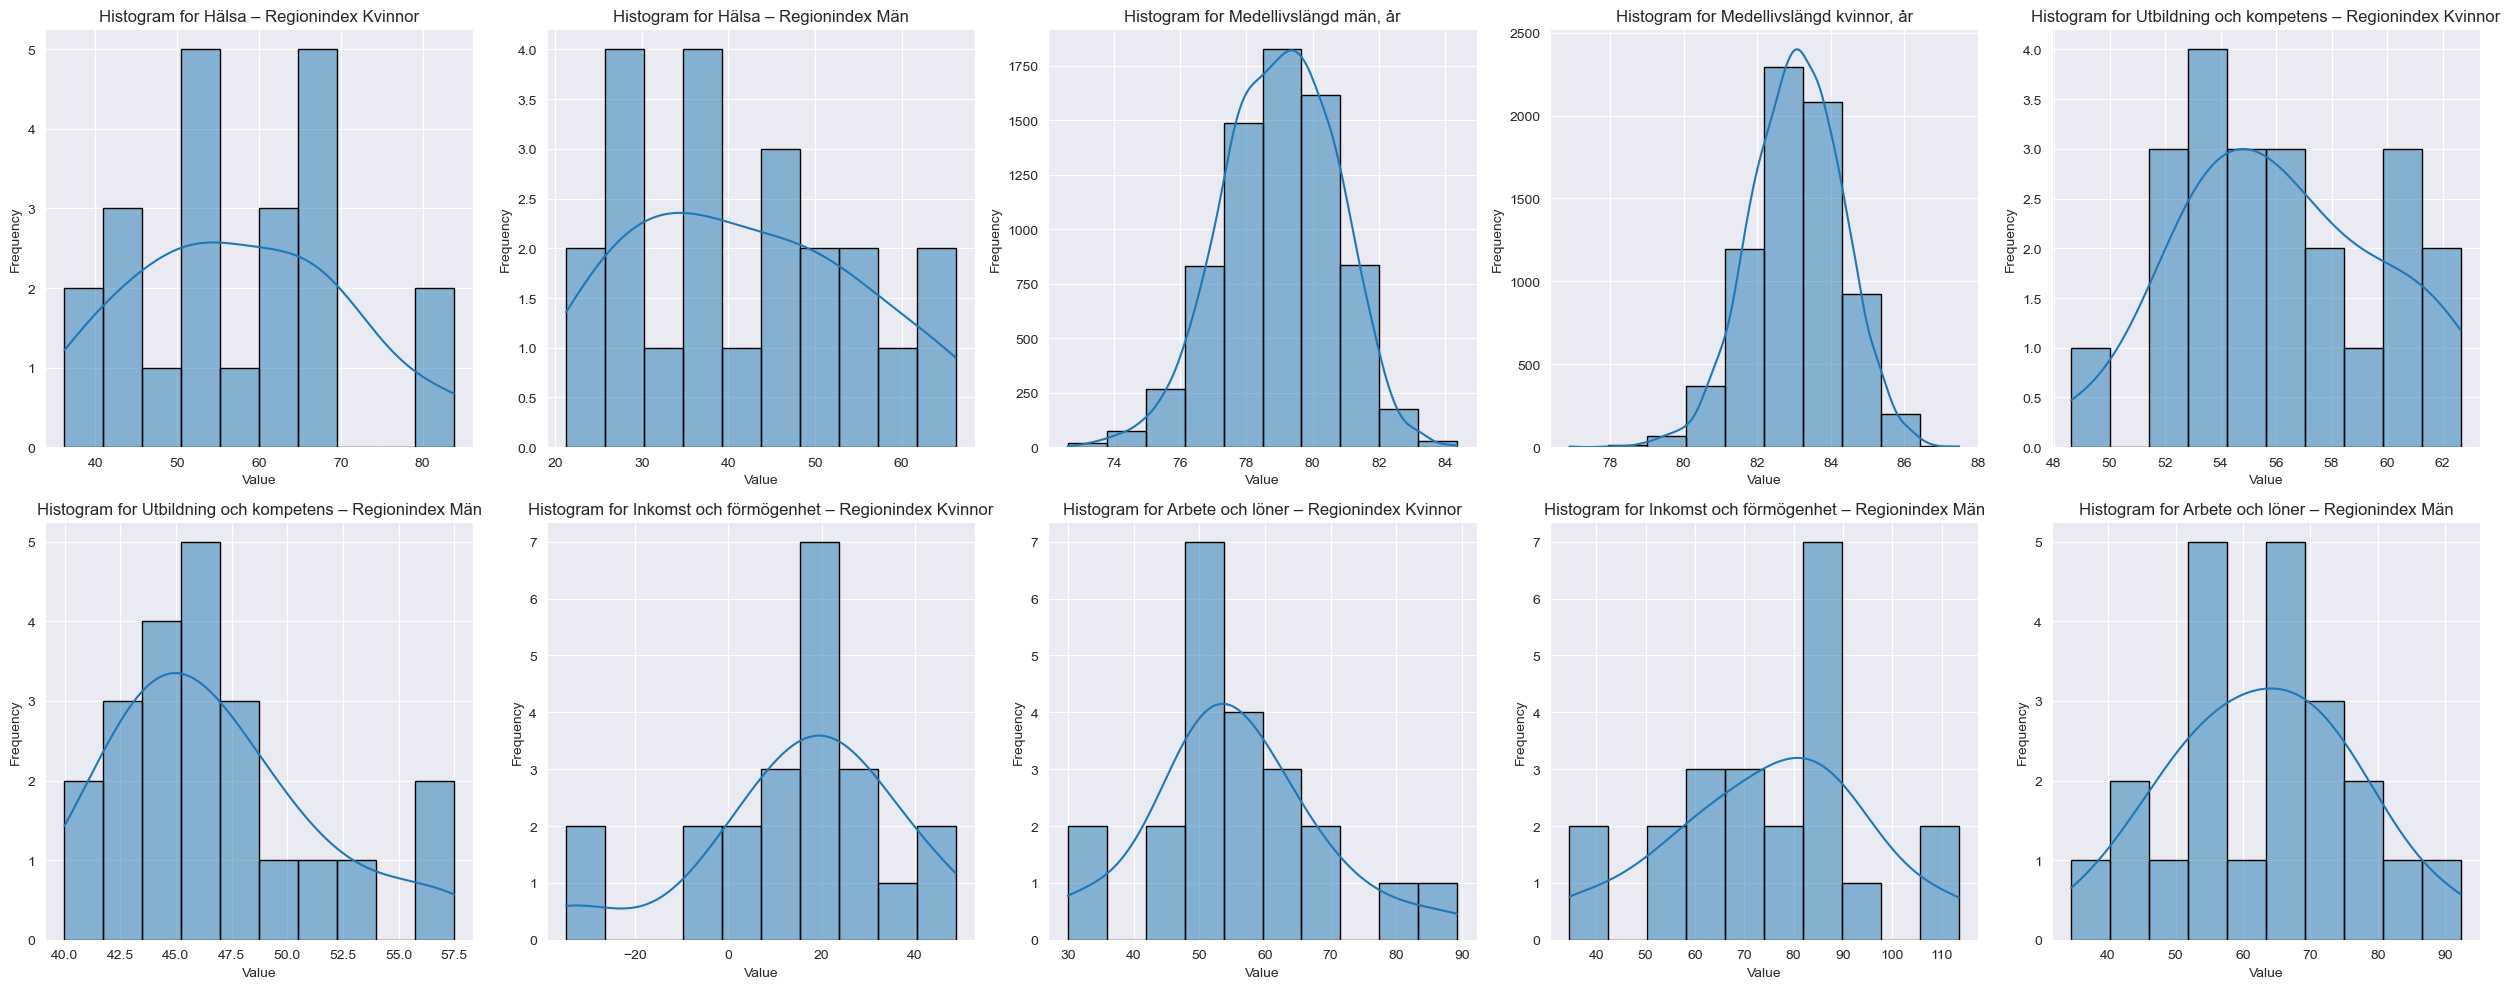

In [10]:
# Create a list with women and men variables
women_men_vars = women_vars + men_vars

# Filter Dataframe to only include the men and women kpis
women_men_df = all_kpis_df[all_kpis_df['kpi'].isin(women_men_vars)]

# Plot histograms to visualize the distributions of the variables
plot_kpi_histograms(women_men_df, kpi_names, raw_income_kpis, num_bins=10, num_cols=5)

### Probability Distribution: Observations
Based on the histograms above we will try to describe the distributions of the following variables:

1. Hälsa - Regionindex Kvinnor/Män N00351/N00362 (Health Index Women/Men): 
The histograms show a relatively symmetric distribution but with some slight deviations from the bell shape. Given this shape we believe that a normal distribution could be an approximate fit. To capture the slight skewness a more nuanced distribution is needed.
2. Inkomst och förmögenheter Kvinnor/Män (Income and Wealth Women/Men): 
These histograms show a right-skewed distribution. The distribution is not symmetric and the right tail is longer than the left tail. Given this shape we believe that a log-normal distribution could be an approximate fit.
3. Utbildning och kompetens Kvinnor/Män (Education and Competence Women/Men):
These histograms show a normal distribution as they show a bell-shaped curve which is symmetric around the mean. Given this shape we believe that a normal distribution could be an approximate fit.
4. Arbete och löner Kvinnor (Work and Salary Women): 
The histogram shows a log-normal distribution as when we apply a log transformation the distribution becomes more symmetric. Given this shape we believe that a log-normal distribution could be an approximate fit.
5. Arbete och löner Män (Work and Salary Men):
The histogram after being log-transformed shows a slight right-skewed distribution. Therefore, we can conclude that this histogram does not perfectly follow a log-normal distribution however is a reasonably close fit.

In [11]:
normal_kpis = ['N00351', 'N00925', 'N00352', 'N00348', 'N00362', 'N00923', 'N00363', 'N00359']
log_normal_kpis = ['N00349', 'N00360']

normal_params, log_normal_params = {}, {}

for kpi in normal_kpis:
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    normal_params[kpi] = {
        'mean': data.mean(),
        'std': data.std()
    }

for kpi in log_normal_kpis:
    # Ensure that data is strictly positive before log transformation
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    data = data[data > 0]

    logged_data = np.log(data)
    log_normal_params[kpi] = {
        'log_mean': logged_data.mean(),
        'log_std': logged_data.std()
    }
    
print(f"Normal distribution parameters:\n{normal_params}\n")
print(f"Log-normal distribution parameters:\n{log_normal_params}\n")

Normal distribution parameters:
{'N00351': {'mean': 57.605825549090916, 'std': 13.27787068958005}, 'N00925': {'mean': 83.06768510757195, 'std': 1.2503488261210622}, 'N00352': {'mean': 56.23213377636364, 'std': 3.6695717260038747}, 'N00348': {'mean': 15.501002725909087, 'std': 21.22065865137951}, 'N00362': {'mean': 41.65425015227272, 'std': 13.576229389627585}, 'N00923': {'mean': 78.99989242805253, 'std': 1.716898888593125}, 'N00363': {'mean': 46.66097596727273, 'std': 4.571473506323352}, 'N00359': {'mean': 75.07445193909092, 'std': 20.624646164415495}}

Log-normal distribution parameters:
{'N00349': {'log_mean': 3.9905474915048087, 'log_std': 0.2501914057484695}, 'N00360': {'log_mean': 4.117573668821707, 'log_std': 0.23220525739536785}}


### Estimation of Parameters Interpreted
#### Normal Distribution Parameters:
* `N00351`: Health Index for Women
  - Mean: 57.61
  - Standard Deviation: 13.28  
  This suggests a moderate average health index with a relatively wide-spread meaning that there is variability among women's health indices.

* `N00925`: Life Expectancy for Women
  - Mean: 83.07
  - Standard Deviation: 1.25  
  This indicates high life expectancy with low variability which shows that that life expectancy for women is quite consistent across the sample.

* `N00352`: Education and Competence for Women
  - Mean: 56.23
  - Standard Deviation: 3.67  
  A moderate average with relatively low variability representing that education and competence scores for women are quite consistent.

* `N00348`: Income and Wealth for Women
  - Mean: 15.50
  - Standard Deviation: 21.22  
  A lower average with very high variability which might suggest a wide disparity in income and wealth among women.

* `N00362`: Health Index for Men
  - Mean: 41.65
  - Standard Deviation: 13.58  
  A lower average compared to women with a wide-spread showing that there is variability among men's health indices.

* `N00923`: Life Expectancy for Men
  - Mean: 79.00
  - Standard Deviation: 1.72  
  High life expectancy with low variability which is similar to women showing a consistent life expectancy for men.

* `N00363`: Education and Competence for Men
  - Mean: 46.66
  - Standard Deviation: 4.57  
  A moderate average with relatively low variability representing that education and competence scores for men are quite consistent.

* `N00359`: Income and Wealth for Men
  - Mean: 75.07
  - Standard Deviation: 20.62  
  A higher average with high variability suggesting a wide disparity in income and wealth among men.

#### Log-normal Distribution Parameters:
* `N00349`: Work and Wages for Women (Log-transformed)
  - Log Mean: 3.99
  - Log Standard Deviation: 0.25  
  After log transformation, the mean and standard deviation suggest that the underlying distribution of logged values is moderately centered with some spread. This reflects multiplicative processes in the wages for women.

* `N00360`: Work and Wages for Men (Log-transformed)
  - Log Mean: 4.12
  - Log Standard Deviation: 0.23  
  Similar to the work and wages for women, after log transformation, the distribution of logged values appears moderately centered with low variability. This reflects multiplicative processes in the wages for men.


### Hypothesis Testing
#### Hypothesis 1:
* Null Hypothesis (H0_1): There is no relationship between income and health.
* Alternative Hypothesis (H1_1): There is a positive relationship between income and health.

#### Hypothesis 2:
* Null Hypothesis (H0_2): There is no relationship between education and health.
* Alternative Hypothesis (H1_2): There is a positive relationship between education and health.

#### Hypothesis 3:
* Null Hypothesis (H0_3): The effect of income on health is greater than or equal to the effect of education on health.
* Alternative Hypothesis (H1_3): The effect of education on health is greater than the effect of income on health.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Filter the DataFrame for Health and Income KPIs
health_df = df_2022[df_2022['kpi'] == 'N00351']
income_df = df_2022[df_2022['kpi'] == 'N00348']

# Pivot the data
health_pivot = health_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'health'})
income_pivot = income_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'income'})

# Merge the pivoted data
merged_df = health_pivot.join(income_pivot, on=['municipality', 'gender'])

# Preform OLS regression using statsmodels
model = smf.ols('health ~ income', data=merged_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     6.331
Date:                Sat, 06 Jan 2024   Prob (F-statistic):             0.0205
Time:                        01:20:23   Log-Likelihood:                -84.574
No. Observations:                  22   AIC:                             173.1
Df Residuals:                      20   BIC:                             175.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.8500      3.157     16.743      0.0

### Hypothesis Testing: Observations
#### Hypothesis 1:
The regression analysis indicates a statistically significant positive relationship between income and health, as evidenced by the significant coefficient for income. This suggests that higher income levels are associated with better health outcomes. The model's R-squared value of approximately 24% indicates that income explains a notable portion of the variance in health scores. However, a significant amount of variability is still left unexplained.

The adjusted R-squared, slightly lower at 20.2%, reflects the model's explanatory power while accounting for the number of predictors. The significant F-statistic further confirms that the model is a better fit than one with no independent variables, reinforcing the relevance of income in predicting health scores.

### Predictive Analysis

* Apply two predictive machine learning models to solve your problem. You can use anything from scikit learn or other libraries.
* Evaluate their performance. Which one do you prefer and why? Conduct hypothesis testing to answer this question.

### Conclusion

* State again your problem and the motivation.
* Draw a final conclusion.
* If you keep working on this project, what would be the next step?   

### References:
- Silhouette (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Silhouette_%28clustering%29 (Accessed: 10 December 2023).